# Imports

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import sys
from rasterio.plot import show

# Load Data

In [2]:
# Step 1: Load Time Series Data
time_series_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\time_series"

# Get the list of all TIFF files in the directory sorted by date
tif_files = sorted([f for f in os.listdir(time_series_dir) if f.endswith('.tif')])

# Load a sample TIFF file to extract coordinate bounds
sample_tif_path = os.path.join(time_series_dir, tif_files[0])

# Step 2: Determine the Coordinate Range
with rasterio.open(sample_tif_path) as src:
    bounds = src.bounds
    crs = src.crs

# Print the coordinate range
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Coordinate Range (Bounding Box):")
print(f"  Min Longitude (West): {bounds.left}")
print(f"  Max Longitude (East): {bounds.right}")
print(f"  Min Latitude (South): {bounds.bottom}")
print(f"  Max Latitude (North): {bounds.top}")

Coordinate Reference System (CRS): EPSG:32720
Coordinate Range (Bounding Box):
  Min Longitude (West): 845580.0
  Max Longitude (East): 847160.0
  Min Latitude (South): 9329240.0
  Max Latitude (North): 9331190.0


### Define the Polygon

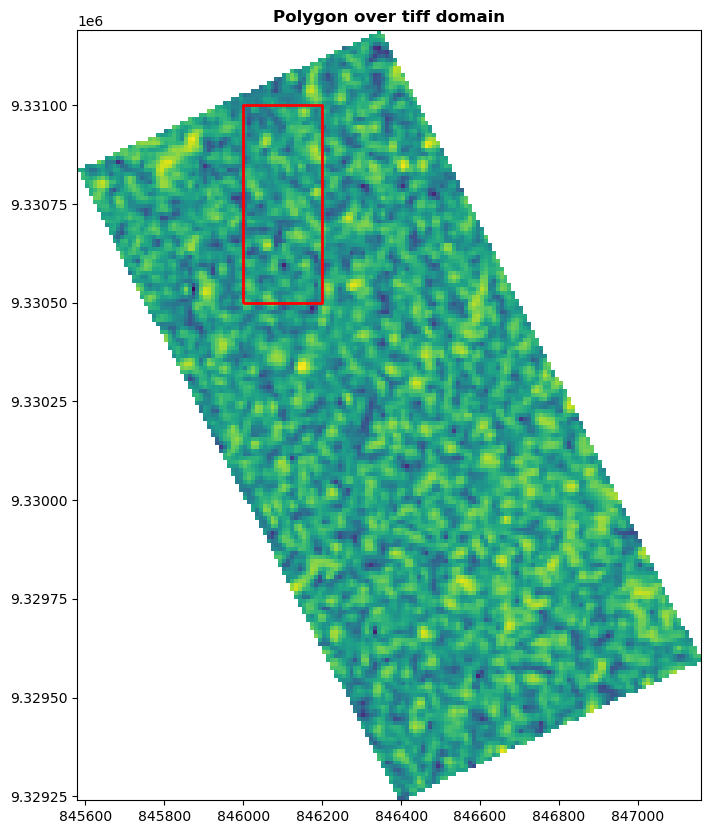

In [3]:
polygon_coords = [
    (846000.0, 9330500.0),
    (846000.0, 9331000.0),
    (846200.0, 9331000.0),
    (846200.0, 9330500.0)
]

polygon = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

# Plot the First TIFF File with the Polygon Overlaid
def plot_tif_with_polygon(tif_path, polygon_gdf):
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title="Polygon over tiff domain")
        polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        ax.set_xlim(src.bounds.left, src.bounds.right)
        ax.set_ylim(src.bounds.bottom, src.bounds.top)
        plt.show()

# Plot the poly over tiff domain
plot_tif_with_polygon(os.path.join(time_series_dir, tif_files[0]), gdf)

# Load model and define functions

In [4]:
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model_tile.pkl'
forest_classifier = joblib.load(model_path)

scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler_tile.pkl'
scaler = joblib.load(scaler_path)


def extract_tile_features(band, i, j, window_size=1):
    """Extract features from a 3x3 tile around the pixel at (i, j) in the band, ensuring no NaNs in the tile."""
    tile = band[max(0, i-window_size):i+window_size+1, max(0, j-window_size):j+window_size+1]
    if np.isnan(tile).any():
        return None
    mean_val = np.nanmean(tile)
    std_val = np.nanstd(tile)
    min_val = np.nanmin(tile)
    max_val = np.nanmax(tile)
    return mean_val, std_val, min_val, max_val

def extract_features(image_data):
    """Extract features from the first two bands (VV, VH) and include ratios to the band 3 mean, excluding NaN-containing tiles."""
    band1, band2, band3 = image_data[0], image_data[1], image_data[2]
    h, w = band1.shape
    features = []

    for i in range(h):
        for j in range(w):
            band1_features = extract_tile_features(band1, i, j)
            band2_features = extract_tile_features(band2, i, j)
            if band1_features and band2_features:  # Only add features if neither are None
                band3_mean = np.nanmean(band3[max(0, i-1):i+2, max(0, j-1):j+2])
                if not np.isnan(band3_mean):
                    band1_ratio = band1[i, j] / band3_mean
                    band2_ratio = band2[i, j] / band3_mean
                    features.append(band1_features + band2_features + (band1_ratio, band2_ratio))
    
    return np.array(features)

# Optional: move Band 3 as feature  
# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) only, excluding Band 3."""
#     band1, band2 = image_data[0], image_data[1]
#     h, w = band1.shape
#     features = []

#     for i in range(h):
#         for j in range(w):
#             band1_features = extract_tile_features(band1, i, j)
#             band2_features = extract_tile_features(band2, i, j)
#             if band1_features and band2_features:
#                 features.append(band1_features + band2_features)
    
#     return np.array(features)

def is_deforested_rate_of_change(previous_percentage, current_percentage, rate_threshold=10):
    """Check if the rate of increase in non-forest percentage exceeds the threshold."""
    return (current_percentage - previous_percentage) > rate_threshold

def smooth_data(data, window_size=5):
    """Apply a moving average to the data to smooth out short-term fluctuations."""
    return pd.Series(data).rolling(window=window_size).mean()

def extract_date_from_filename(filename):
    """Extract the date from the filename, assuming the date is in a specific position."""
    date_str = filename.split('_')[4]  # Adjust based on your file name pattern
    return datetime.strptime(date_str, "%Y%m%dT%H%M%S").date()

def classify_and_detect_deforestation(polygon_gdf, tif_files, method='rate_and_level'):
    # Sort the files by date before processing
    tif_files = sorted(tif_files, key=extract_date_from_filename)
    
    previous_classification = None
    total_files = len(tif_files)
    non_forest_summary = []
    initial_predictions = None
    initial_file_date = None
    final_predictions = None
    final_file_date = None
    deforestation_detected = False
    deforestation_date = None

    for index, tif_file in enumerate(tif_files):
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)

            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []

            for i in range(h):
                for j in range(w):
                    tile_features = extract_features(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                continue

            valid_features = np.vstack(valid_features)
            valid_features_normalized = scaler.transform(valid_features)
            predictions = forest_classifier.predict(valid_features_normalized).reshape(h, w)

            if initial_predictions is None:
                initial_predictions = predictions
                initial_file_date = extract_date_from_filename(tif_file)

            final_predictions = predictions
            final_file_date = extract_date_from_filename(tif_file)

            non_forest_pixels = np.sum(predictions == 0)
            total_pixels = predictions.size
            non_forest_percentage = (non_forest_pixels / total_pixels) * 100

            non_forest_summary.append((final_file_date, non_forest_percentage))

            if index > 0 and is_deforested_rate_of_change(non_forest_summary[index-1][1], non_forest_percentage):
                if not deforestation_detected and non_forest_percentage > 50:
                    deforestation_detected = True
                    deforestation_date = final_file_date
                    print(f"\nDeforestation detected on: {deforestation_date}")
                    visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
                    visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)

            previous_classification = predictions

    if initial_predictions is not None and final_predictions is not None and deforestation_detected:
        visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, out_transform)
        visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, out_transform)

    plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_date)

    if deforestation_detected:
        print(f"\nDeforestation detected on: {deforestation_date}")
    else:
        print("\nNo significant deforestation detected in the given time series.")

def plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_date=None):
    """Plot the non-forest percentage over time with custom point colors based on file name prefix and mark deforestation detection date."""
    dates, percentages = zip(*non_forest_summary)

    colors = []
    for tif_file in tif_files:
        if tif_file.startswith('S1A'):
            colors.append('green')
        elif tif_file.startswith('S1B'):
            colors.append('red')
        else:
            colors.append('blue')

    plt.figure(figsize=(14, 7))
    plt.plot(dates, percentages, linestyle='-', color='blue', alpha=0.7, label='Non-Forest %')

    for i, (date, percentage) in enumerate(zip(dates, percentages)):
        plt.scatter(date, percentage, color=colors[i], s=50)

    if deforestation_date:
        plt.axvline(deforestation_date, color='red', linestyle='--', label=f'Deforestation Detected on {deforestation_date}')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Non-Forest Percentage (%)')
    plt.title('Non-Forest Percentage Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def visualize_predictions(initial_predictions, initial_file_date, deforestation_predictions, deforestation_file_date, transform):
    """Visualize the initial and deforestation date predictions side by side with a binary legend and projection values."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    cmap = mcolors.ListedColormap(['brown', 'green'])
    
    im1 = axes[0].imshow(initial_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * initial_predictions.shape[1],
                                                                 transform[5] + transform[4] * initial_predictions.shape[0], transform[5]])
    axes[0].set_title(f"Initial Predictions on {initial_file_date}")
    axes[0].set_xlabel("X Projection (m)")
    axes[0].set_ylabel("Y Projection (m)")

    im2 = axes[1].imshow(deforestation_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * deforestation_predictions.shape[1],
                                                                       transform[5] + transform[4] * deforestation_predictions.shape[0], transform[5]])
    axes[1].set_title(f"Predictions on Deforestation Date {deforestation_file_date}")
    axes[1].set_xlabel("X Projection (m)")
    axes[1].set_ylabel("Y Projection (m)")

    legend_labels = {0: 'Non-Forest', 1: 'Forest'}
    patches = [plt.matplotlib.patches.Patch(color=cmap(i), label=legend_labels[i]) for i in legend_labels]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)
    
    plt.tight_layout()
    plt.show()

def visualize_change_groups(initial_predictions, deforestation_predictions, initial_file_date, deforestation_file_date, transform):
    """Visualize the changes in land cover with four groups based on the deforestation file date."""
    
    min_h = min(initial_predictions.shape[0], deforestation_predictions.shape[0])
    min_w = min(initial_predictions.shape[1], deforestation_predictions.shape[1])
    
    initial_predictions = initial_predictions[:min_h, :min_w]
    deforestation_predictions = deforestation_predictions[:min_h, :min_w]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    map_output = np.zeros_like(initial_predictions)

    map_output[(initial_predictions == 1) & (deforestation_predictions == 1)] = 1  
    map_output[(initial_predictions == 1) & (deforestation_predictions == 0)] = 2  
    map_output[(initial_predictions == 0) & (deforestation_predictions == 0)] = 3  
    map_output[(initial_predictions == 0) & (deforestation_predictions == 1)] = 4  

    cmap = mcolors.ListedColormap(['green', 'red', 'brown', 'lightgreen'])
    
    im = ax.imshow(map_output, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * map_output.shape[1],
                                                  transform[5] + transform[4] * map_output.shape[0], transform[5]])

    ax.set_title(f"Land Cover Change: Initial ({initial_file_date}) to Deforestation ({deforestation_file_date})")
    ax.set_xlabel("X Projection (m)")
    ax.set_ylabel("Y Projection (m)")

    legend_labels = {
        1: 'Forest stayed Forest',
        2: 'Forest deforested',
        3: 'Non-Forest stayed Non-Forest',
        4: 'Non-Forest became Forest'
    }
    patches = [plt.matplotlib.patches.Patch(color=cmap(i-1), label=legend_labels[i]) for i in range(1, 5)]
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout() 
    plt.show()

Processing file 2 out of 241...
Deforestation detected on: 2016-01-17


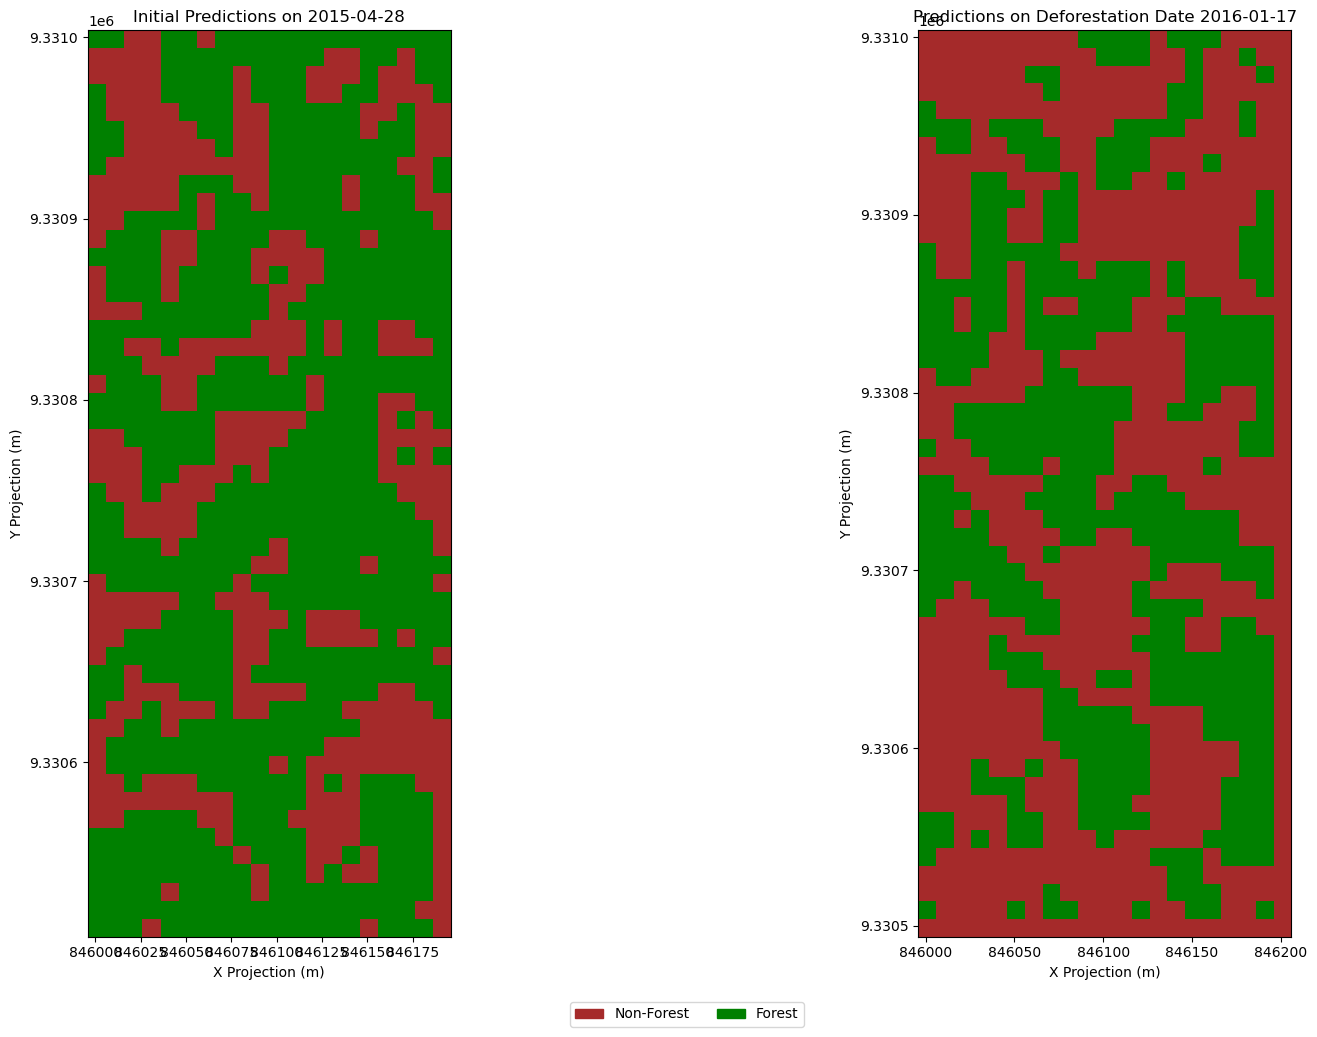

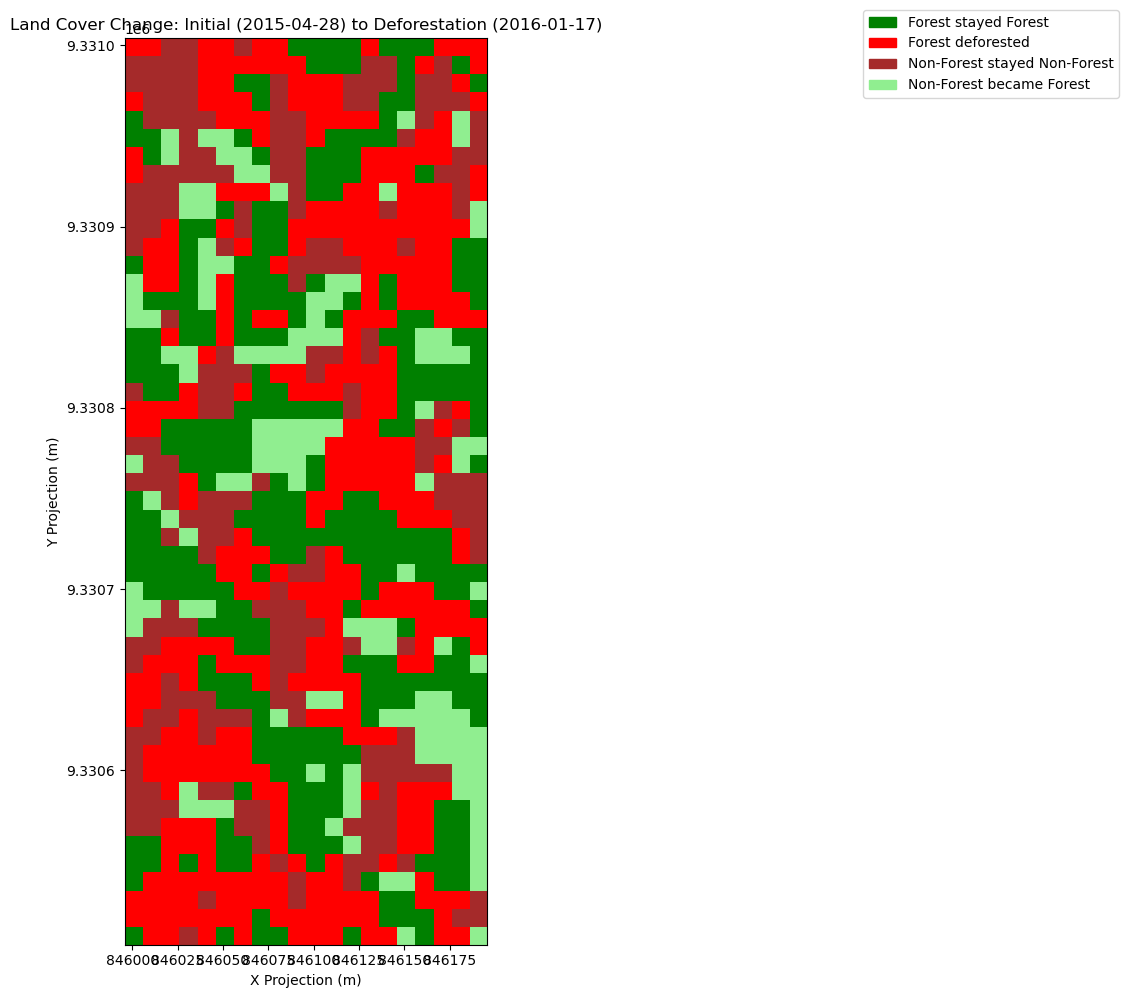

Processing file 241 out of 241...

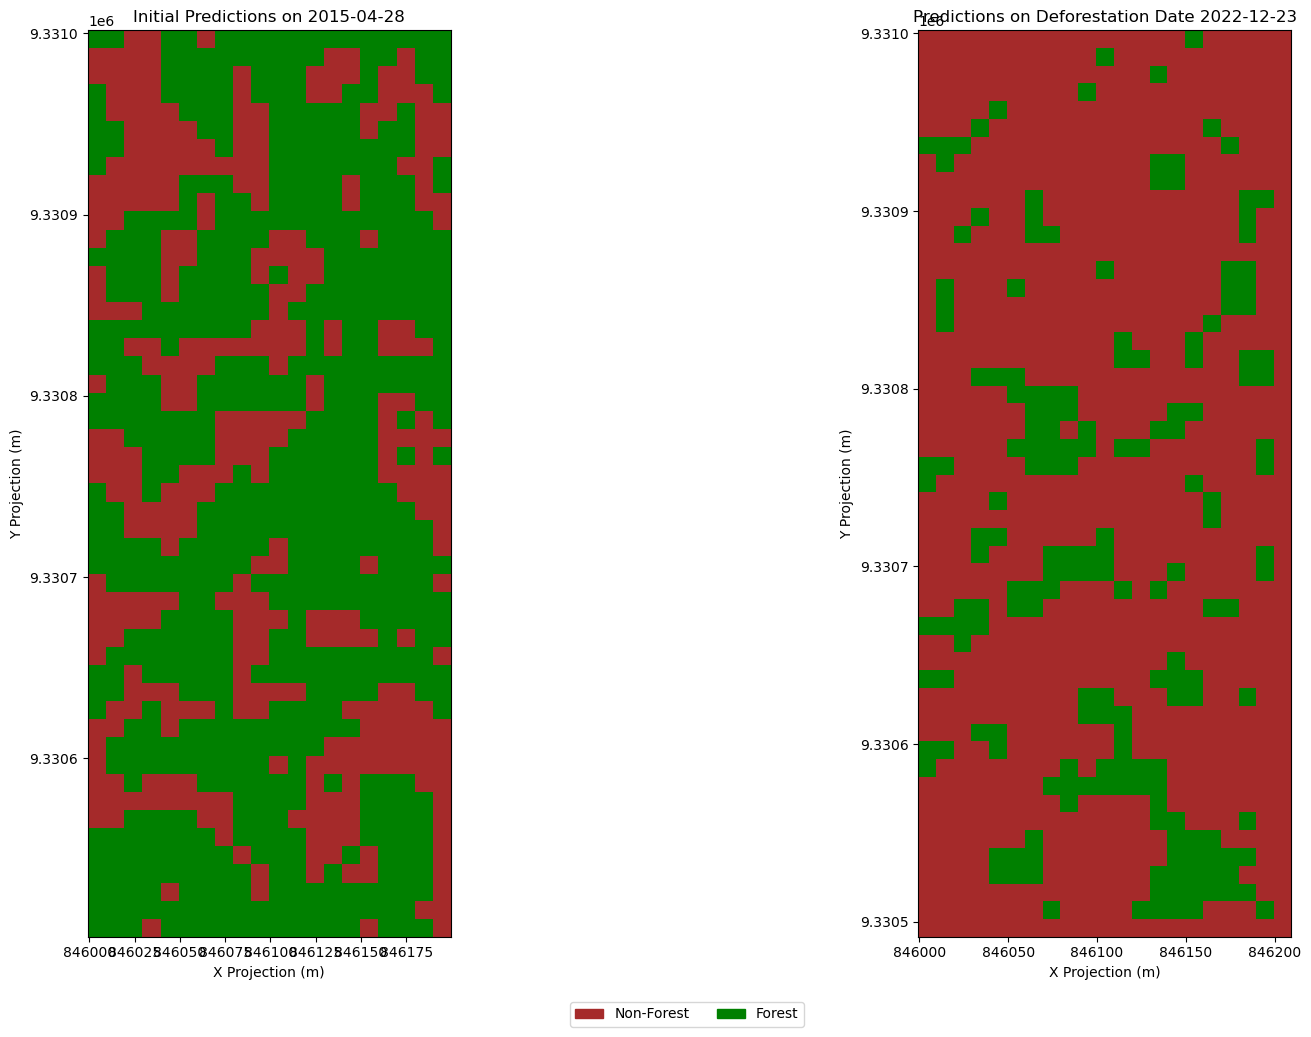

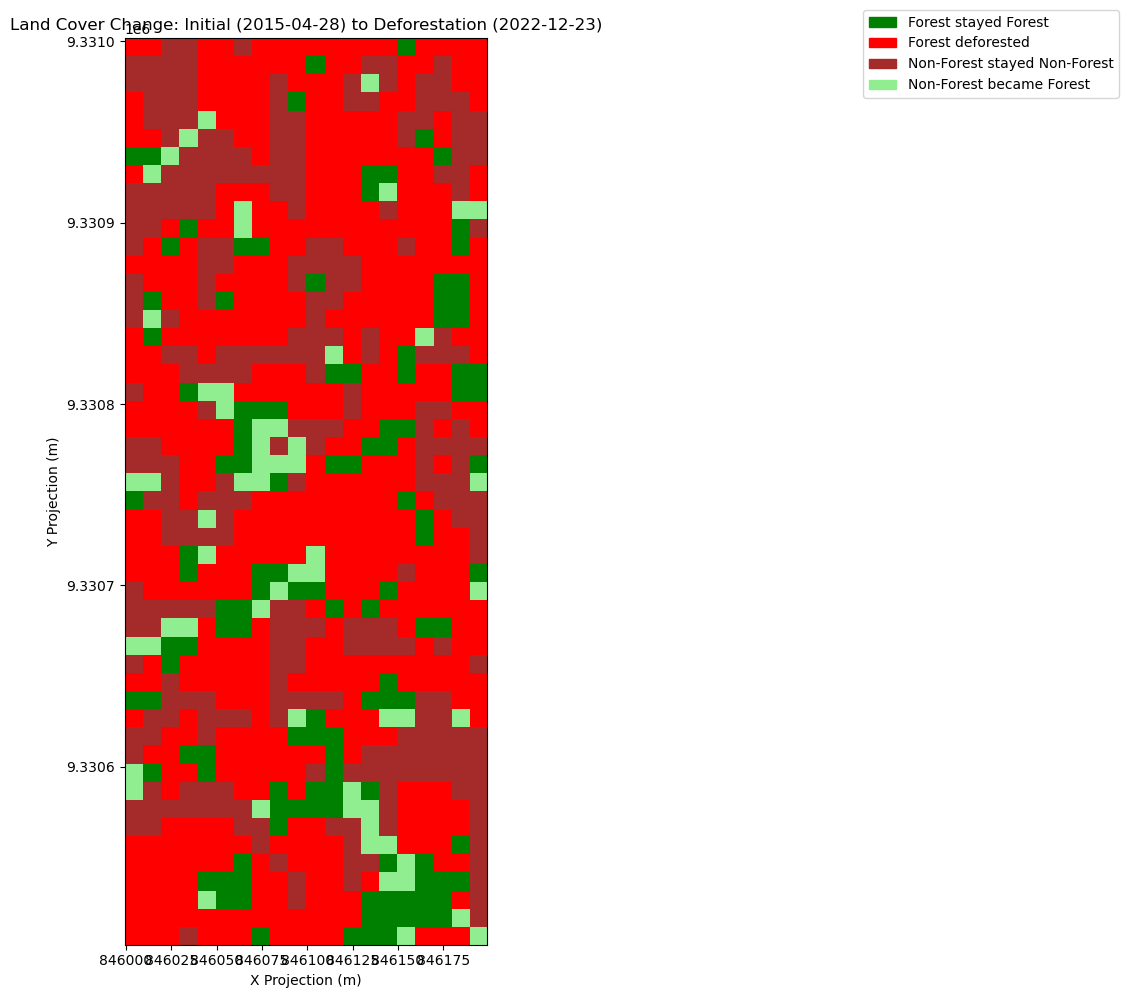

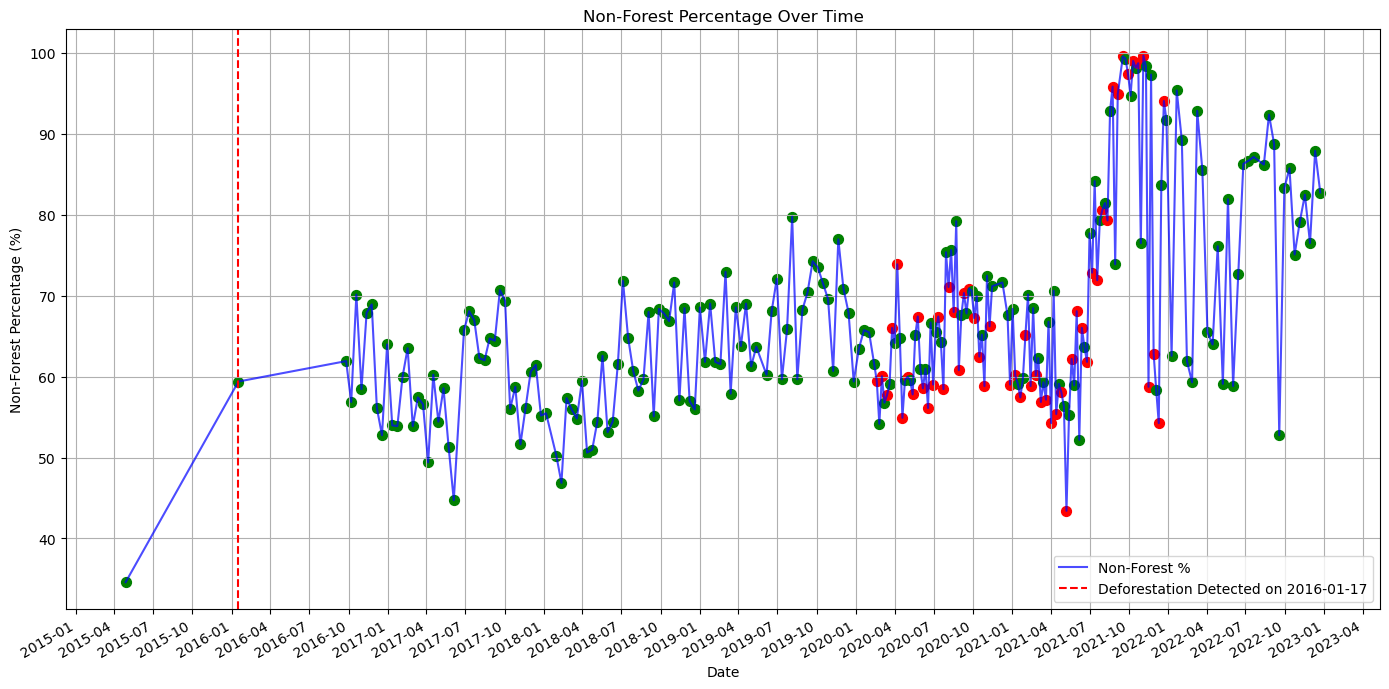


Deforestation detected on: 2016-01-17


In [5]:
# Run the detection function with the rate_and_level method
classify_and_detect_deforestation(gdf, tif_files, method='rate_and_level')